In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pretty_midi
import librosa
import IPython.display
import librosa.display
import pickle

print("imported")

imported


In [2]:
# rolls = []
# for file in glob("type0/*.midi"):
#     pm = pretty_midi.PrettyMIDI(file)
#     pm.remove_invalid_notes()
#     rolls.append(pm.get_piano_roll(fs=50))

# def cutter(roll,length=250):
#     dims = roll.shape
#     num_imgs = dims[1]//length
#     out=np.zeros((num_imgs,128,length))
#     for i in range(0,num_imgs):
#         out[i,:,:]=roll[:,i*length:(i+1)*length]
#     return out

# def append_all_cuts(rls):
#     seq = tuple(cutter(r) for r in rls)
#     return np.concatenate(seq)

# rawDataset=append_all_cuts(rolls)

# plt.figure(figsize=(10, 6))
# plt.subplot(211)
# librosa.display.specshow(rawDataset[2000], y_axis='cqt_note', cmap=plt.cm.hot)

223
223


/usr/local/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


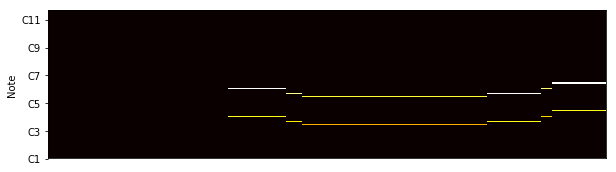

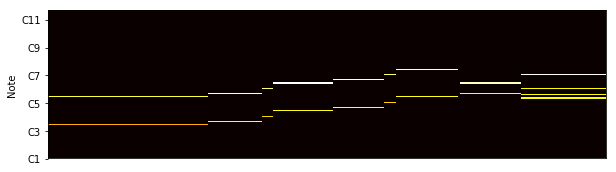

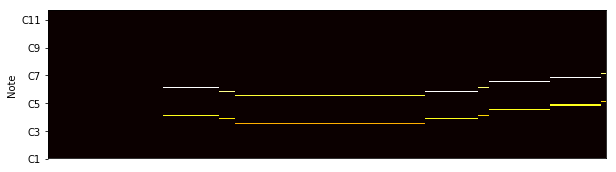

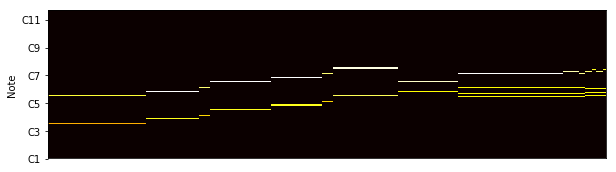

In [3]:
rolls = []
counter = 0
for file in glob("type0/app*.midi"):
    pm = pretty_midi.PrettyMIDI(file)
    pm.remove_invalid_notes()
    rolls.append(pm.get_piano_roll(fs=50))
#     counter += 1
#     if counter == 25:
#         break

def cutter(roll,length=250):
    dims = roll.shape[1]
    dims2 = roll.shape[1]-length//2
    num_imgs = dims//length + dims2//length
    out=np.zeros((num_imgs,128,length))
    for i in range(0,num_imgs, 2):
        if dims-1-i*length>=length:
            out[i,:,:]=roll[:,i*length:(i+1)*length]
        if dims-1 - (i*(length)+length//2)>=length: 
            out[i+1,:,:]=roll[:,i*(length)+length//2:(i+1)*(length)+length//2]
    return out

def append_all_cuts(rls):
    seq = tuple(cutter(r) for r in rls)
    return np.concatenate(seq)

rawDataset=append_all_cuts(rolls)
# rawDataset.savez("roll_cuts.npz")
#corresponding variable names, in the .npz file, are ‘arr_0’, ‘arr_1’, etc. 
print(len(rawDataset))

print(len(rawDataset))
plt.figure(figsize=(10, 6))
plt.subplot(211)
librosa.display.specshow(rawDataset[0], y_axis='cqt_note', cmap=plt.cm.hot)
plt.figure(figsize=(10, 6))
plt.subplot(211)
librosa.display.specshow(rawDataset[1], y_axis='cqt_note', cmap=plt.cm.hot)
plt.figure(figsize=(10, 6))
plt.subplot(211)
librosa.display.specshow(rawDataset[2], y_axis='cqt_note', cmap=plt.cm.hot)
plt.figure(figsize=(10, 6))
plt.subplot(211)
librosa.display.specshow(rawDataset[3], y_axis='cqt_note', cmap=plt.cm.hot)

In [4]:
rawDataset.shape

(223, 128, 250)

In [5]:
import sparse

In [6]:
s = sparse.COO(rawDataset)
#rawdata = s.todense() 

In [7]:
with open("data/rawdata",'wb') as f:
    pickle.dump(s, f)
    #np.savez(f, data=rawDataset)

In [8]:
def piano_roll_to_pretty_midi(piano_roll, fs=50, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


In [10]:
sample = rawDataset[100]
print(sample.shape)
# print(sample[sample>0])
midi=piano_roll_to_pretty_midi(sample,fs=50,program=11)

IPython.display.Audio(midi.fluidsynth(fs=44100),rate=44100)

(128, 250)


In [ ]:
midi=piano_roll_to_pretty_midi(rawDataset[12000],fs=50,program=11)
midi.write("new_midi.midi")

In [ ]:
rawDataset.shape

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from pushover import notify
from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2
print("IMPORTED")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
bs = 32 # batchsize
# Load Data
dataset = datasets.ImageFolder(root='trainings/faces', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [ ]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [ ]:
image_channels = fixed_x.size(1)

In [ ]:
model = VAE(image_channels=image_channels).to(device)
model_version = "AC-nimgs_2515-epochs_50"
model.load_state_dict(torch.load('models/vae.torch-' + model_version, map_location='cpu'))

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 50

In [ ]:
def compare(x):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

In [ ]:
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x)

sample_filename = 'sample_image-{}.png'.format(model_version)
save_image(compare_x.data.cpu(), sample_filename)
display(Image(sample_filename, width=300, unconfined=True))